# Analyze and visualize last.fm listening history

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [4]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
The Kinks              2764
David Bowie            2589
The Beatles            2431
Belle and Sebastian    2190
Radiohead              2157
Name: play_count, dtype: int64

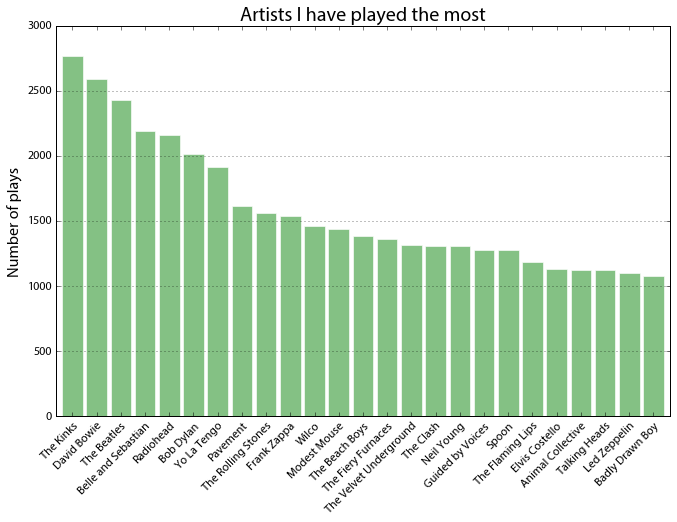

In [5]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.85, alpha=0.6, color='#339933', edgecolor='w')

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [6]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')
index = tracks_most.apply(lambda x: '{}\n{}'.format(x['artist'], x['track']), axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Wolf Parade\nModern World                 133
The Kinks\nWaterloo Sunset                127
Badly Drawn Boy\nOnce Around the Block    117
The Zombies\nThis Will Be Our Year        113
The Kinks\nDays                           105
Name: play_count, dtype: int64

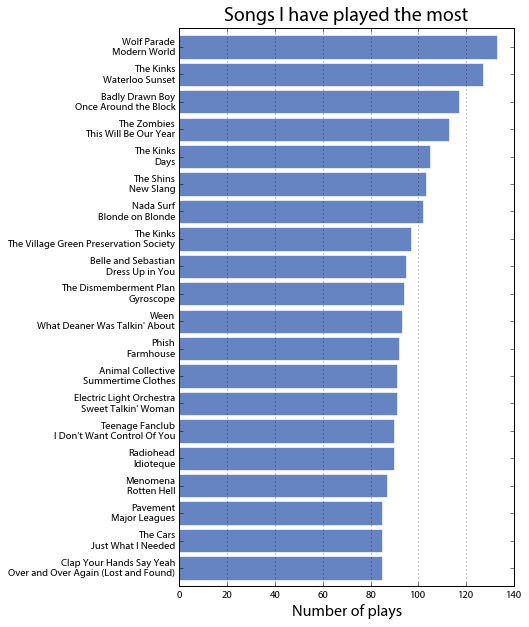

In [7]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.85, alpha=0.6, color='#003399', edgecolor='w')
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [8]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')
index = albums_most.apply(lambda x: '{}\n{}'.format(x['artist'], x['album']), axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

The Kinks\nThe Kink Kronikles                 746
Frank Black\nTeenager of the Year             704
Devo\nPioneers Who Got Scalped                690
The Zombies\nOdessey and Oracle               675
Badly Drawn Boy\nThe Hour of Bewilderbeast    613
Name: play_count, dtype: int64

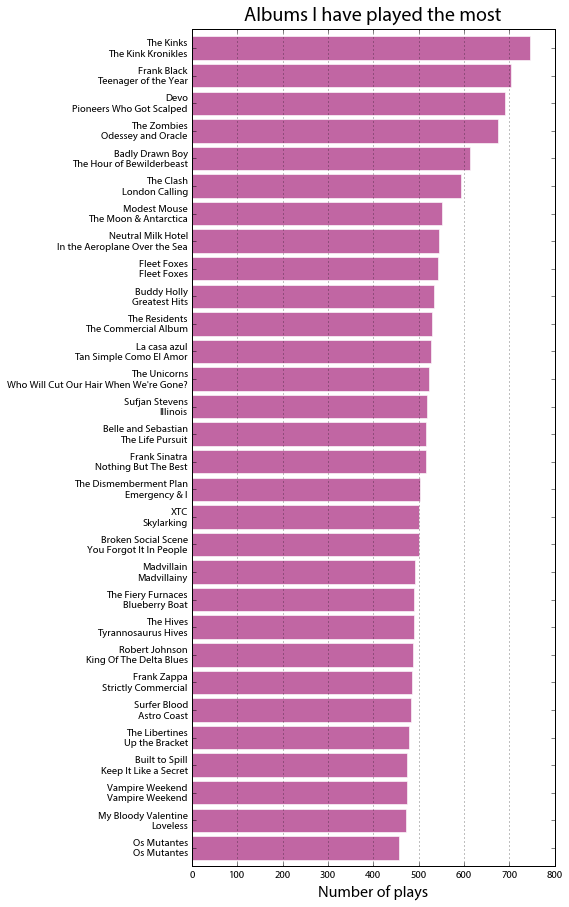

In [9]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.85, alpha=0.6, color='#990066', edgecolor='w')
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [10]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

237,739 total scrobbles
21,468 total artists


According to the last.fm web site, I have ~266,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [11]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [12]:
# functions to convert UTC to Pacific time zone and extract date/time elements
convert_tz = lambda x: x.to_datetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [13]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Тарас Чубай,5788c6df-063e-4df3-99e9-99c607f64d6b,Скрябін: Концерт пам'яті (Live),NaN,Птахи - Live,NaN,2016-07-06 15:56:19,2016,2016-07,6,8,2
1,Fidel Sax Bateke,NaN,"Nigeria Special Volume 2: Modern Highlife, Afr...",NaN,Motako,NaN,2016-07-06 15:51:27,2016,2016-07,6,8,2
2,George Stavis,e625dc47-d5b4-4485-88ef-e0208f8b7389,"Imaginational Anthem, Vol. Three",NaN,Goblins,fdc2498b-3743-41d2-87d2-319e83d8ff41,2016-07-06 15:50:43,2016,2016-07,6,8,2
3,Bhaskar Chandavarkar,805ec7ca-46e1-4a8e-94eb-6d1b96353aaf,Soundscapes - Music of the Seas,NaN,Coastal Garba,NaN,2016-07-06 15:46:34,2016,2016-07,6,8,2
4,Serdar Keskin,926e9461-192a-428b-bd8d-72ee86904009,Leyl,NaN,Dön Bak Şu Bizim İklime,NaN,2016-07-06 15:44:03,2016,2016-07,6,8,2


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

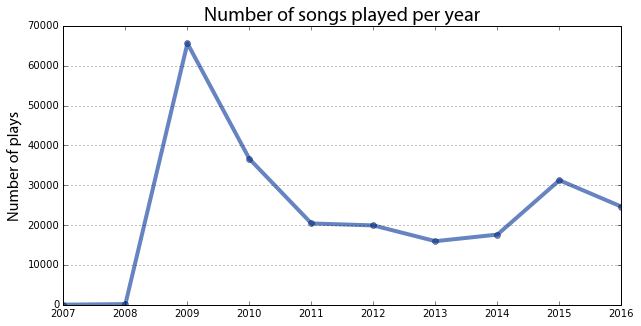

In [14]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth='4', alpha=0.6, marker='o', color='#003399')

ax.yaxis.grid(True)
ax.set_xticklabels(year_counts.index, rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [15]:
# get all the scrobbles from 2010-present
min_year = 2010
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [16]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

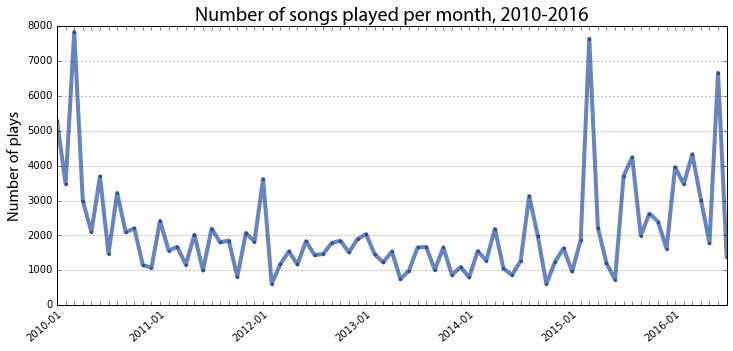

In [17]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth='4', alpha=0.6, marker='.', color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylim((0,8000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [18]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

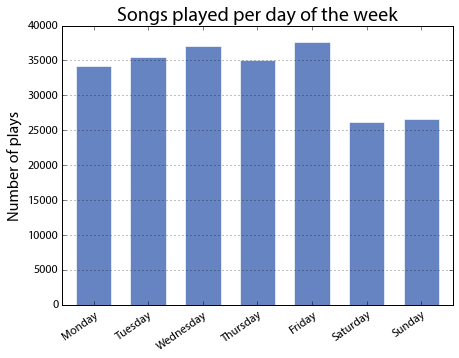

In [19]:
ax = dow_counts.plot(kind='bar', figsize=[7, 5], width=0.65, alpha=0.6, color='#003399', edgecolor='w')

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

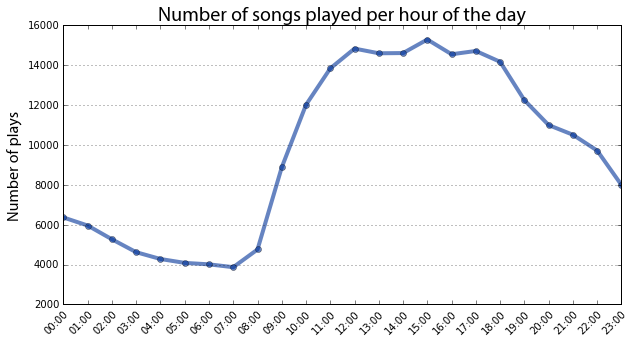

In [20]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth='4', alpha=0.6, marker='o', color='#003399')

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [21]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

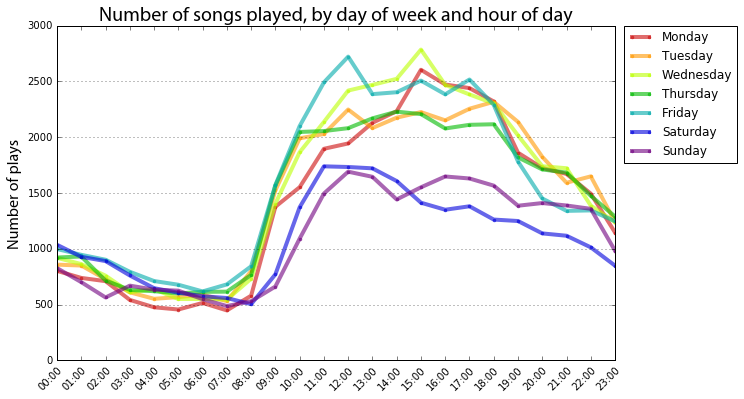

In [22]:
# get one color per day of week
colors = get_colors('spectral', n=len(day_numbers), start=0.05, stop=0.95, reverse=True)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth='4', alpha=0.6, marker='.', color=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [23]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2015])]
len(scrobbles_year)

31252

In [24]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Radiohead,255
2,Bob Dylan,198
3,Yo La Tengo,196
4,Modest Mouse,169
5,The Kinks,160
6,The Rolling Stones,147
7,The Beatles,147
8,Beirut,144
9,David Bowie,129
10,Moondog,108


In [25]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Shintaro Sakamoto,"You Can Be A Robot, Too",23
2,Porches,The Cosmos,21
3,Panda Bear,Mr Noah,20
4,Father John Misty,Hollywood Forever Cemetery Sings,20
5,Jamie xx,I Know There's Gonna Be (Good Times),19
6,Hinds,Bamboo,19
7,Cherry Glazerr,Had Ten Dollaz,18
8,Orange Juice,Falling and Laughing,18
9,The King Khan & BBQ Show,I’ll Be Loving You,18
10,Zachary Cale,Sundowner,17


In [26]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,Jonathan Richman And The Modern Lovers,Roadrunner: The Beserkley Collection,83
2,Alvvays,Alvvays,68
3,The Rolling Stones,The Rolling Stones Singles Box Set,64
4,Sufjan Stevens,Carrie & Lowell,60
5,Beirut,The Flying Club Cup,59
6,Radiohead,The Bends,58
7,Buena Vista Social Club,Buena Vista Social Club,56
8,Real Estate,Atlas,53
9,Moondog,H'art Songs,53
10,Townes Van Zandt,Live at the Old Quarter,52


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [27]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2014-02'])]
len(scrobbles_month)

1552

In [28]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,David Bowie,63
2,Mac DeMarco,47
3,Talking Heads,45
4,Wild Nothing,41
5,Islands,26
6,Eluvium,26
7,The Babies,25
8,Wu-Tang Clan,25
9,The Microphones,24
10,CHVRCHES,24


In [29]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,The Babies,Moonlight Mile,15
2,Vampire Weekend,Ladies of Cambridge,13
3,Islands,Becoming the Gunship,13
4,Mac DeMarco,My Kind of Woman,13
5,The Magnetic Fields,You Must Be Out Of Your Mind,11
6,CHVRCHES,The Mother We Share,11
7,Taj Mahal,Lovin' in My Baby's Eyes,11
8,Wild Nothing,Live In Dreams,11
9,Gladys Knight & The Pips,Midnight Train to Georgia,10
10,Wild Nothing,Chinatown,10


In [30]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Talking Heads,The Name of This Band Is Talking Heads,39
2,Mac DeMarco,2,34
3,Wild Nothing,Gemini,30
4,The Babies,Our House on the Hill,23
5,Eluvium,An Accidental Memory in the Case of Death,20
6,Islands,Ski Mask,17
7,David Bowie,Station to Station,16
8,Blood Orange,Cupid Deluxe,15
9,Derek and the Dominos,Layla And Other Assorted Love Songs,14
10,The Notwist,Close To The Glass,13


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [31]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('My Bloody Valentine')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
8473,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,When You Sleep,ebd67461-fbe7-4f48-a68a-0a57ee8a15c9,2016-05-19 20:53:01,2016,2016-05,19,13,3
8512,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,When You Sleep,ebd67461-fbe7-4f48-a68a-0a57ee8a15c9,2016-05-19 18:08:16,2016,2016-05,19,11,3
8761,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,When You Sleep,ebd67461-fbe7-4f48-a68a-0a57ee8a15c9,2016-05-16 23:38:38,2016,2016-05,16,16,0
25049,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,Sometimes,9839b527-a36d-4efb-8682-526601be5131,2015-12-14 22:03:43,2015,2015-12,14,14,0
25482,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,Sometimes,9839b527-a36d-4efb-8682-526601be5131,2015-12-10 01:07:06,2015,2015-12,9,17,2


In [32]:
# when were the last 5 times I played something off of Double Nickels on the Dime?
scrobbles[scrobbles['album'].fillna('').str.contains('Double Nickels')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
14421,Minutemen,d4ad0149-d8ae-4105-8009-0221fce9ff35,Double Nickels on the Dime,e7e28af9-2f2e-46c9-a08f-5e6215054a5e,History Lesson Part 2,NaN,2016-03-18 22:02:33,2016,2016-03,18,15,4
14503,Minutemen,d4ad0149-d8ae-4105-8009-0221fce9ff35,Double Nickels on the Dime,e7e28af9-2f2e-46c9-a08f-5e6215054a5e,Two Beads at the End,c677d2d5-7d64-417b-a039-464fed21af59,2016-03-18 19:12:22,2016,2016-03,18,12,4
14516,Minutemen,d4ad0149-d8ae-4105-8009-0221fce9ff35,Double Nickels on the Dime,e7e28af9-2f2e-46c9-a08f-5e6215054a5e,Dr. Wu,NaN,2016-03-18 18:48:25,2016,2016-03,18,11,4
14544,Minutemen,d4ad0149-d8ae-4105-8009-0221fce9ff35,Double Nickels on the Dime,e7e28af9-2f2e-46c9-a08f-5e6215054a5e,Themselves,6b95389f-2dcb-474f-9992-315bb0a759d9,2016-03-18 18:02:38,2016,2016-03,18,11,4
17830,Minutemen,d4ad0149-d8ae-4105-8009-0221fce9ff35,Double Nickels on the Dime,e7e28af9-2f2e-46c9-a08f-5e6215054a5e,History Lesson Part 2,NaN,2016-02-25 22:27:05,2016,2016-02,25,14,3


In [33]:
# when were the last 5 times I played Personality Crisis?
scrobbles[scrobbles['track'].str.contains('Personality Crisis')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
1569,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-06-26 23:15:40,2016,2016-06,26,16,6
18391,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-02-23 02:52:54,2016,2016-02,22,18,0
25258,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2015-12-12 04:30:46,2015,2015-12,11,20,4
27599,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2015-11-11 00:10:29,2015,2015-11,10,16,1
44239,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2015-04-18 04:21:11,2015,2015-04,17,21,4


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [34]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']
top_artists = plays.index.levels[0]

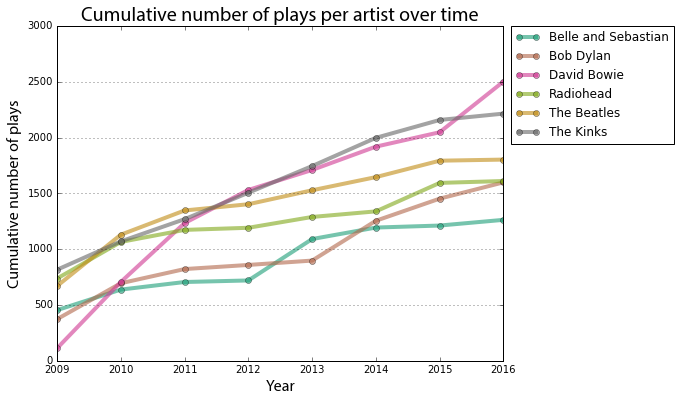

In [35]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth='4', alpha=0.6, marker='o', color=c)
    lines.append(artist)
    
ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.395,1.017))

plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [36]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

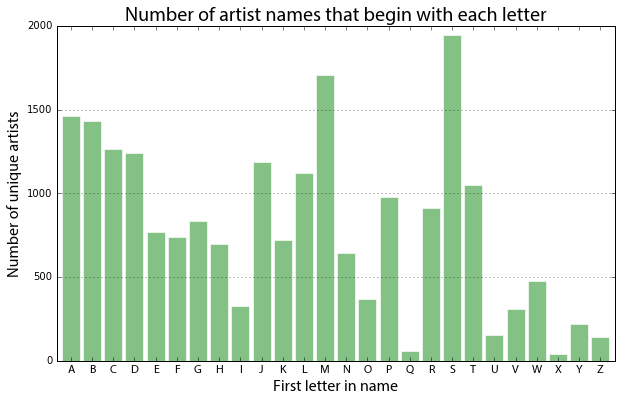

In [37]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.85, alpha=0.6, color='#339933', edgecolor='w')
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [38]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['Xavier Quijas Yxayotl', 'Xabi AburruzagA', 'Xenia Rubinos', 'Xiu Xiu', 'Xavier Cugat', 'Xu Jiangde', 'Xiang Sihua', 'Xavier Cugat & His Orchestra', 'Xiao Changhua', 'Xun Huisheng', 'Xia Yifeng', 'Xutik', 'XXYYXX', 'xx', 'X-Ray Spex', 'XTC', 'X', 'Xcerts', 'Xandria', 'Xavier Naidoo', 'Ximena Sariñana', 'XY&O', 'X Ambassadors', 'Xylouris White', 'xolo', 'Xmal Deutschland', 'X-Marks the Pedwalk', 'XYconstant', 'XO MAN', 'XO', 'XYLØ', 'Xinobi', 'Xinlisupreme', 'Xatar', 'Xristos Menidiatis', 'Xeno & Oaklander', 'X-Men', 'Xavier Davis', 'xL', 'Xploding Plastix', 'Xororó', 'Xibalba']"

In [39]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Michael    38
Maria      26
Mark       25
Mary       21
Martin     21
MC         21
Matt       21
Mike       18
Mc         17
Max        17
Mr.        17
My         15
Marc       15
Magic      10
Modern      9
dtype: int64

In [40]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the        1424
los         132
john         82
dj           68
david        60
black        51
peter        45
james        43
big          40
la           39
el           39
mc           38
michael      38
paul         38
little       38
dtype: int64

In [41]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

band         214
orchestra    174
his          114
john         102
black         86
ensemble      85
dj            84
trio          78
david         73
james         67
brothers      65
new           62
paul          53
big           52
king          50
dtype: int64

In [42]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Adam Baldych, Baltic Gang, Lars Danielsson, Jacob Karlzon, Morten Lund, Verneri Pohjola & Marius Neset"


In [43]:
# what is the distribution of lengths of artist names (number of characters)?
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:51].reindex(range(51), fill_value=0)

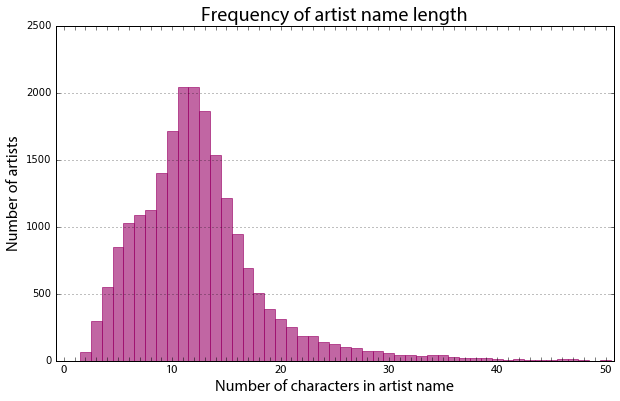

In [44]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066')

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()